## Классификации эмоций в аудио

На основе датасета аудио RAVDESS и модели Wav2Vec2.0 нужно научиться предсказывать эмоции на тестовой выборке

**Подготовка датасета**

Датасет RAVDESS состоит из аудио, озвученных 24 разными актёрами, в равной пропорции женщинами и мужчинами. Каждый актёр озвучил каждую фразу каждой эмоцией по два раза, правда разных фраз всего было две - "Kids are talking by the door" и "Dogs are sitting by the door". Помимо прочего, в датасете есть сила эмоции normal и strong, но для neutral эмоции strong нет.

По большому счёту нам интересна только сама эмоция, так как ничего остального предсказывать нас не просят, и никаких дополнительных фичей в тренировочном датасете нет.

In [1]:
!pip install numpy
!pip install librosa
!pip install ffmpeg
!pip install torch
!pip install transformers
!pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [9]:
import librosa
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
from tqdm import tqdm

In [12]:
Ravdess = "Github/data/Ravdess/"
ravdess_directory_list = os.listdir(Ravdess)

files_emotion = []
files_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part represents the emotion
        files_emotion.append(int(part[2]))
        files_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(files_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(files_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,angry,Github/data/Ravdess/Actor_21/03-01-05-02-02-02...
1,calm,Github/data/Ravdess/Actor_21/03-01-02-01-01-02...
2,surprise,Github/data/Ravdess/Actor_21/03-01-08-02-01-01...
3,sad,Github/data/Ravdess/Actor_21/03-01-04-02-02-02...
4,surprise,Github/data/Ravdess/Actor_21/03-01-08-02-02-01...


<Axes: xlabel='Emotions', ylabel='Count'>

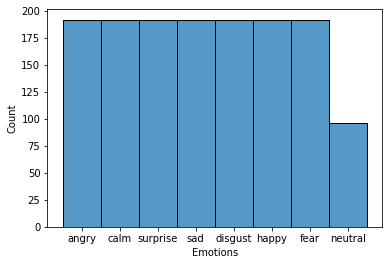

In [4]:
sns.histplot(data=Ravdess_df, x="Emotions")

Классы не сбалансированны из-за того, что для neutral только одна интенсивность и, соответсвенно, в два раза меньше записей

## Wav2Vec2

Теперь извлечём фичи из наших аудио с помощью эмбеддингов предобученной Wav2Vec2. Для этого мы прогоним наши аудио через модель и получим состояние последнего скрытого слоя. Уже на этих значениях, как фичах, будем тренировать собственный классификатор

In [77]:
# Initialising

# we use the facebook pretrained model
model_name = "facebook/wav2vec2-large-xlsr-53"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = Wav2Vec2Model.from_pretrained(model_name)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Будем использовать частоту дискретизации 16k, так как на этом значении обучалась Wav2Vec2. Помимо этого, в документации указано, что нормализация входящего аудио может существенно улучшить результаты, так что сделаем это

In [101]:
def get_feature(input_audio):
    
    # normilising the input, so that it has zero mean and unit variance
    normalised_input = feature_extractor(input_audio, return_tensors="pt", 
                                         feature_size=1, sampling_rate=sample_rate,
                                        padding=True)

    with torch.no_grad():
        # getting the representation in Wav2Vec2
        outputs = model(normalised_input.input_values, output_hidden_states=True)

    embeddings = outputs.last_hidden_state

    return np.mean(embeddings[0].numpy(), axis=0).astype(np.float32)

In [120]:
features = []

for file_path in tqdm(Ravdess_df.Path):
    input_audio, sample_rate = librosa.load(file_path,  sr=16000)
    features.append(get_feature(input_audio))

features = np.array(features)

100%|███████████████████████████████████████| 1440/1440 [16:15<00:00,  1.48it/s]


In [121]:
features.shape

(1440, 1024)

In [15]:
with open('Github/data/features', 'wb') as f:
    np.save(f, features)

In [16]:
with open('Github/data/train_labels', 'wb') as f:
    np.save(f, np.array(files_emotion))

## Классификация

Сравним несколько несложных классификаторов, а затем выберем лучший. В качестве рассматриваемых классификаторов возьмём Случайный Лес и Градиентный бустинг

**Случайный лес**

Его трудно переобучить и он хорошо справляется с нахождением нелинейных зависимостей. Часто он не сильно уступает в качестве сложным нейронным сетям. Помимо этого, уже обученный лес очень быстро делает предсказания.

Воспользуемся готовой реализацией от sklearn. Необходимо подобрать оптимальные гиперпараметры - это в первую очередь max_depth каждого дерева и n_estimators - количество деревьев

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

In [17]:
X = pd.DataFrame(features)
y = pd.Series(Ravdess_df.Emotions)

In [240]:
# Инициализируем валидацию
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100, 150, 200, 350, 400]

# Обучаем на тренировочном датасете
for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 41.74% with 350 trees


Text(0.5, 0, 'N_estimators')

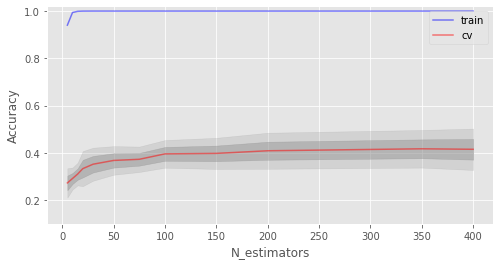

In [247]:
plt.style.use('ggplot')
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.1,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators")

Утверждается, что оптимальное значение в сетке поиска - 350. Можно было бы перебрать больше значений в районе 350, но видно, что после 200 accuracy выходит на плато, так что можно не исследовать дальше

In [251]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=350, random_state=42, n_jobs=-1, oob_score=True, 
                                 max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 40.90% with 17 max_depth


Text(0.5, 0, 'Max_depth')

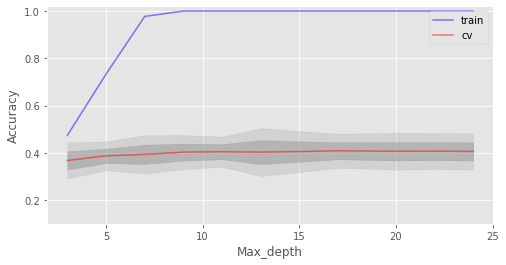

In [252]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.1,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth")

С max_depth аналогичная ситуация. После 10 модель выходит на плато. Оптимальное значение достигается на 17

Итоговая accuracy - 40,9%. Это может показаться небольшим, но меток классов 8, то есть "подбрасывание монетки" дало бы нам только 12.5%. В других работах на аналогичных данных достигается accuracy в 60% https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition

**Градиентный бустинг**

Родственная модель к случайному лесу, но которая как правило всё-таки показывает себя лучше и эффективнее. К ней применим аналогичное исследование

In [408]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(warm_start=True, max_depth=5, 
                                 learning_rate=0.1, subsample=1,
                                n_estimators=1000)

In [411]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [2, 3, 5, 7, 11, 13, 17, 19]

# Обучаем на тренировочном датасете
for max_depth in max_depth_grid:
    rfc = GradientBoostingClassifier(warm_start=True, max_depth=max_depth, 
                                 learning_rate=0.1)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

KeyboardInterrupt: 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y)

clf.fit(X_train, y_train)
print("Train: ", clf.score(X_train, y_train))
print("Test: ", clf.score(X_test, y_test))

In [407]:
y_predicted = clf.predict(X_test)
accuracy_score(y_test, y_predicted)

0.20378151260504201

In [2]:
import pickle
# save the model to disk
filename = 'GradientBoostingClassifier_weights.sav'
pickle.dump(clf, open(filename, 'wb'))

NameError: name 'clf' is not defined

In [1]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

NameError: name 'pickle' is not defined

In [359]:
y_predicted = loaded_model.predict(X_test)
accuracy_score(y_test, y_predicted)

0.8256302521008403

In [398]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y)

clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(1000, 20), 
                    max_iter=100, warm_start=True)
history = clf.fit(X_train, y_train)

clf.score(X_train, y_train)
clf.score(X_test, y_test)

0.20378151260504201

In [399]:
history

MLPClassifier(hidden_layer_sizes=(1000, 20), max_iter=100, solver='lbfgs',
              warm_start=True)

## Аугментации

На самом деле, у нас не очень то много данных, если подумать. При этом добавление шумов или небольшое повышение тональности не должно изменять нам метку класса. То есть можно увеличить объём тренировочных данных в несколько раз.